In [14]:
pip install optuna

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

SEED = 1234

# Cargar el conjunto de datos
datos = pd.read_csv("/content/drive/MyDrive/Temp_Asu20092021 (2).csv")

# Convertir la columna 'Fecha' al tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

# Filtrar datos a partir de 2019
datos = datos[datos.index.year >= 2019]

# Eliminar filas con valores faltantes
datos.dropna(inplace=True)

# Calcular los percentiles 95, 50 (mediana) y 5 para cada día
percentiles_diarios = datos.resample('D')['Temperatura'].agg([lambda x: np.percentile(x, 95),
                                                              lambda x: np.percentile(x, 50),
                                                              lambda x: np.percentile(x, 5)])
percentiles_diarios.columns = ['Percentil_95', 'Mediana', 'Percentil_5']

# Desplazar para obtener los percentiles del siguiente día como variables objetivo
percentiles_diarios['Percentil_95_siguiente_dia'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_siguiente_dia'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_siguiente_dia'] = percentiles_diarios['Percentil_5'].shift(-1)

# Eliminar filas con valores faltantes
percentiles_diarios.dropna(inplace=True)

# Seleccionar características
X = percentiles_diarios[['Percentil_95', 'Mediana', 'Percentil_5']].values
y = percentiles_diarios[['Percentil_95_siguiente_dia', 'Mediana_siguiente_dia', 'Percentil_5_siguiente_dia']].values

# Escalar las características
scaler_X = StandardScaler()
X_escalado = scaler_X.fit_transform(X)

# Dividir datos en conjuntos de entrenamiento y validación
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_escalado, y, test_size=0.2, random_state=SEED, shuffle=False)

# Definir función objetivo para Optuna
def objetivo(trial):
    num_capas = trial.suggest_int('num_capas', 1,2, 3)
    num_unidades = trial.suggest_categorical('num_unidades', [16, 32, 64])


    tf.keras.utils.set_random_seed(SEED)

    # Definir la arquitectura del modelo
    modelo = Sequential()
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))


    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))


    # Capa de salida para predecir los 3 percentiles (95, 50, 5)
    modelo.add(Dense(3, activation='linear'))

    # Compilar el modelo
    modelo.compile(optimizer=Adam(),
                   loss='mse',
                   metrics=['mae'])

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=30, batch_size=256, verbose=0, shuffle=False)

    # Evaluar el modelo en el conjunto de validación
    _, val_mae = modelo.evaluate(X_validacion, y_validacion, verbose=0)

    return val_mae

# Realizar la optimización de hiperparámetros usando Optuna
estudio = optuna.create_study(direction='minimize')
estudio.optimize(objetivo, n_trials=10)

# Obtener los mejores hiperparámetros
mejor_num_capas = estudio.best_params['num_capas']
mejor_num_unidades = estudio.best_params['num_unidades']


print("Mejores Hiperparámetros:")
print("Número de Capas:", mejor_num_capas)
print("Número de Unidades:", mejor_num_unidades)

resultados = estudio.trials_dataframe()

# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(3, activation='linear'))

modelo_final.compile(optimizer=Adam(),
                     loss='mse',
                     metrics=['mae'])

# Entrenar el modelo final
modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=50, batch_size=256, verbose=1, shuffle=False)

# Evaluar en conjunto de prueba
mae = modelo_final.evaluate(X_validacion, y_validacion, verbose=0)
print(f'MAE en validación: {mae}')


[I 2024-09-11 20:45:17,884] A new study created in memory with name: no-name-5741f2fc-e359-4aa1-a5dd-e4a4feac1f1d
<ipython-input-15-182d8300eae0>:53: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_capas = trial.suggest_int('num_capas', 1,2, 3)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
[I 2024-09-11 20:45:21,431] Trial 0 finished with value: 21.93014144897461 and parameters: {'num_capas': 1, 'num_unidades': 16}. Best is trial 0 with value: 21.93014144897461.
[I 2024-09-11 20:45:24,108] Trial 1 finished with value: 21.93014144897461 and parameters: {'num_capas': 1, 'num_unidades': 16}. Best is trial 0 with value: 21.93014144897461.
[I 2024-09-11 20:45:27,733] Trial 2 finished with value: 21.118589401245117 and parameters: {'num_

Mejores Hiperparámetros:
Número de Capas: 1
Número de Unidades: 64
Epoch 1/50
4/4 [==============================] - 1s 43ms/step - loss: 636.9104 - mae: 24.1508 - val_loss: 588.8467 - val_mae: 22.9064
Epoch 2/50
4/4 [==============================] - 0s 9ms/step - loss: 634.0806 - mae: 24.0923 - val_loss: 586.0829 - val_mae: 22.8439
Epoch 3/50
4/4 [==============================] - 0s 11ms/step - loss: 631.2285 - mae: 24.0332 - val_loss: 583.2867 - val_mae: 22.7806
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 628.3392 - mae: 23.9732 - val_loss: 580.4520 - val_mae: 22.7162
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 625.4023 - mae: 23.9122 - val_loss: 577.5688 - val_mae: 22.6506
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 622.4093 - mae: 23.8498 - val_loss: 574.6271 - val_mae: 22.5834
Epoch 7/50
4/4 [==============================] - 0s 9ms/step - loss: 619.3480 - mae: 23.7858 - val_loss: 571.6180 - val_mae: 

# **Graficos de dispersión entre el valor real y la predicción**

7/7 [==============================] - 0s 2ms/step


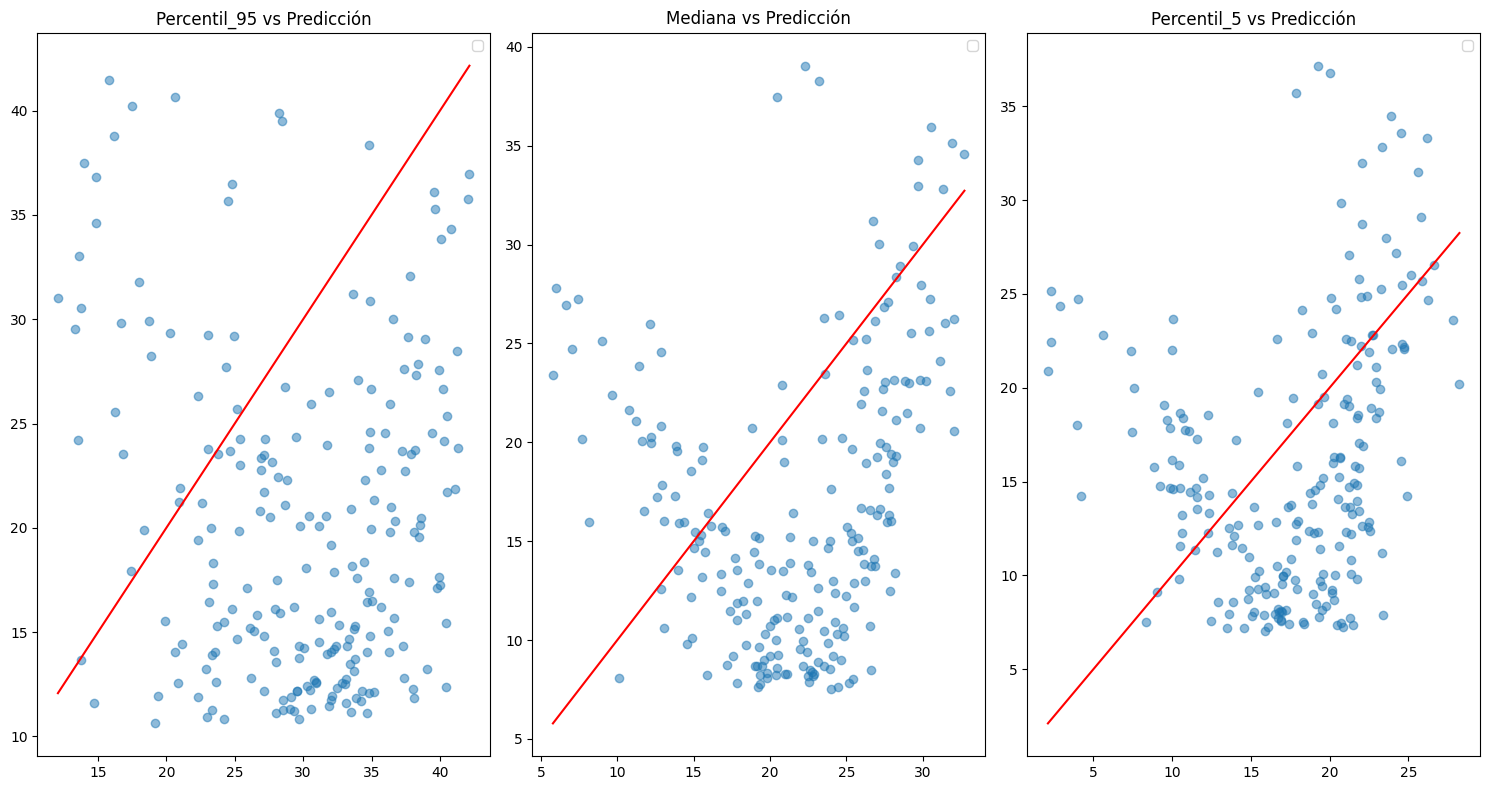

(2.115947058857478, 28.246711939666238)

In [45]:
import matplotlib.pyplot as plt


predicciones = modelo_final.predict(X_validacion)
plt.figure(figsize=(15, 8))

nombres = ['Percentil_95', 'Mediana', 'Percentil_5']#Para la iteracion


for i, nombre in enumerate(nombres):
    plt.subplot(1, 3, i+1)#   Cant de gradicos
    plt.scatter(y_validacion[:, i], predicciones[:, i], alpha=0.5)

    plt.plot([min(y_validacion[:, i]), max(y_validacion[:, i])],
             [min(y_validacion[:, i]), max(y_validacion[:, i])], 'r')#Une los puntos minimos y max

    plt.title(f'{nombre} vs Predicción')
    plt.legend()

plt.tight_layout()
plt.show()
min(y_validacion[:, i]), max(y_validacion[:, i])

# **Curva de Aprendizaje**

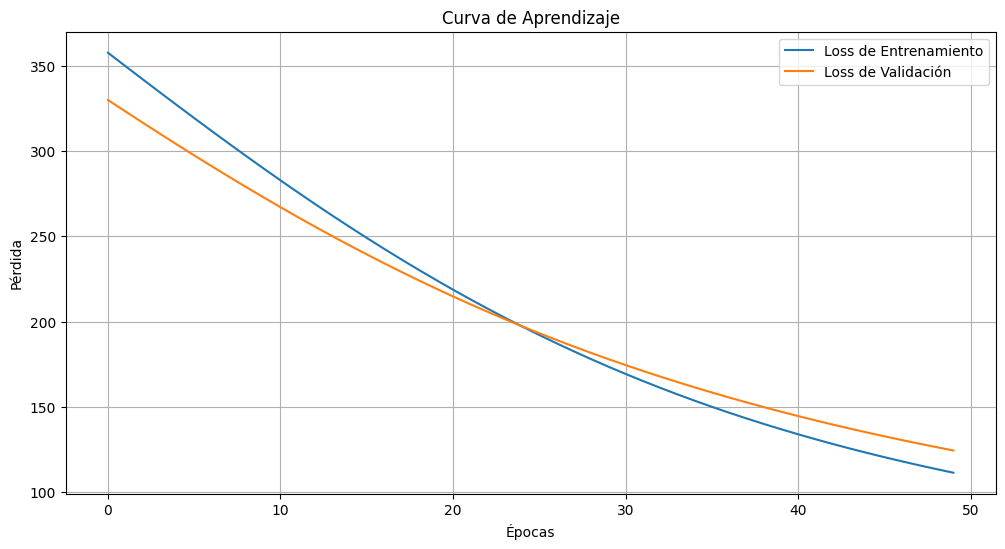

In [16]:
import matplotlib.pyplot as plt

historial = modelo_final.fit(X_entrenamiento, y_entrenamiento,
                             validation_data=(X_validacion, y_validacion),
                             epochs=50, batch_size=256, verbose=0, shuffle=False)

plt.figure(figsize=(12, 6))
plt.plot(historial.history['loss'], label='Loss de Entrenamiento')
plt.plot(historial.history['val_loss'], label='Loss de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid(True)
plt.show()



# **10 mejores resultados del optuna**

In [27]:
resultados
resultados_ordenados = resultados.sort_values(by='value', ascending=True)#Ordena los mejores valores
resultados_ordenados.head(10)
print(resultados_ordenados[['params_num_capas', 'params_num_unidades', 'value']])

   params_num_capas  params_num_unidades  value
3                 1                   64  20.43
5                 1                   64  20.43
9                 1                   64  20.43
2                 1                   32  21.12
4                 1                   32  21.12
6                 1                   32  21.12
8                 1                   32  21.12
0                 1                   16  21.93
1                 1                   16  21.93
7                 1                   16  21.93
